Для выполнения этого задания я решил получать данные по вакансиям с hh.ru
Особенность поиска количества вакансий в сфере IT является неоднозначность градации уровня соискателя(Junior, Middle, Senior). Нет точных критериев, которые относят специалиста к определенному уровню. В некоторых вакансиях изначально прописывается предполагаемый уровень работника.

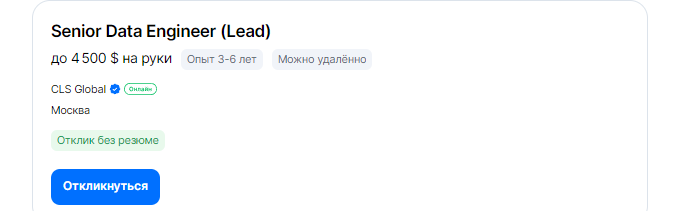

А в некоторых вакансиях такая информация отсутствует.

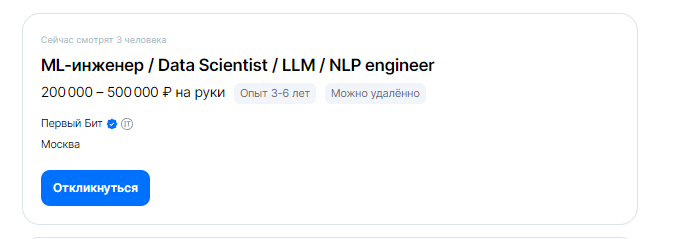

Мой алгоритм основан на получении сначала количества вакансий, где уровень соискателя явно указан в названии/описании вакансии, а потом к этому числу добавляются вакансии без определенного уровня в названии/описании, но с указанным необходимым опытом работы. Для однозначности решения я взял такое возможное разбиение градации уровня специалиста относительно опыта работы:

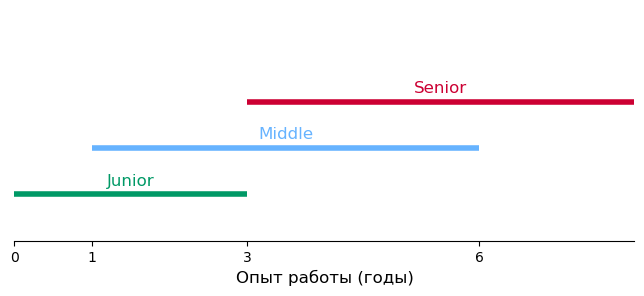

In [1]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(figsize=(8, 3))
ax.set_xlim(0, 8)
ax.set_ylim(0, 5)
ax.set_xticks([0, 1, 3, 6])
ax.set_yticks([])
ax.text(1.5, 1.2, 'Junior', fontsize=12, ha='center', color='#009966')
ax.text(3.5, 2.2, 'Middle', fontsize=12, ha='center', color='#66b3ff')
ax.text(5.5, 3.2, 'Senior', fontsize=12, ha='center', color='#CC0033')
ax.hlines(1, 0, 3, colors='#009966', linewidth=4, label='Junior')
ax.hlines(2, 1, 6, colors='#66b3ff', linewidth=4, label='Middle')   
ax.hlines(3, 3, 8, colors='#CC0033', linewidth=4, label='Senior')     
ax.set_xlabel('Опыт работы (годы)', fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.show()

In [4]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
import pandas as pd
import re
#Настройка браузера для парсинга
chrome_options = Options()
chrome_options.add_argument("--disable-gpu")
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--start-maximized")
chrome_options.add_argument("--disable-dev-shm-usage")
chrome_options.add_argument("--headless")
chrome_options.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.83 Safari/537.36")

service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=chrome_options)

#На hh.ru каждому реиону присвоен свой уникальный id
areas_ids = {"Москва":"1",
            "Санкт-Петербург":"2",
            "Нижний Новгород":"66"}


tracks = ["Data+Analyst", "Data+Scientist", "Data+Engineer"]
levels = ["Junior", "Middle", "Senior"]
areas = ["Москва", "Санкт-Петербург", "Нижний Новгород"]

vacancies_data = []


base_url = "https://hh.ru/search/vacancy"


def get_expreience_list(level):
    if(level == "Junior"):
        return ["noExperience","between1And3"]
    elif(level == "Middle"):
        return ["between1And3","between3And6"]
    elif(level == "Senior"):
        return ["between3And6","moreThan6"]

def get_number_of_vacancies(track,level,area,experience):
    location = areas_ids.get(area)
    if(not(experience)):
        #Формируем URL для поиска вакансий по направлению и уровню без фильтрации по опыту работы
        search_url = f"{base_url}?text={track}+{level}&search_field=name&area={location}"
    else:
        #Формируем URL с дополнительным параметром experience для фильтрации по опыту работы
        #Добавляем в excluded_text слова junior, middle, senior, чтобы повторно не прибавить уже учтенные ранее вакансии
        search_url = f"{base_url}?text={track}&search_field=name&area={location}&experience={experience}&excluded_text=junior%2C+middle%2C+senior"
    driver.get(search_url)
    try:
        html_content = driver.page_source
        soup = BeautifulSoup(html_content, "html.parser")
        #Ищем заголовок, который содержит информацию о количестве вакансий
        vacancy_header = soup.find("h1", {"data-qa": "title"})
        count = int(re.search(r"\d+", vacancy_header.text).group())
        if(experience):
            print(f"Получено: {track} ({level}) в {area}: {count} вакансий, с опытом работы: {experience}")
        else:
            print(f"Получено: {track} ({level}) в {area}: {count} вакансий")
        print(f"Url: {search_url}")
    except Exception as e:
        count = 0
        if(not(experience)):
            print(f"Нет вакансий по запросу {track} ({level}) в {area}")
        else:
            print(f"Нет вакансий по запросу {track} ({level}) в {area}, с опытом работы: {experience}")
        print(f"Url: {search_url}")

    return count


In [5]:
for track in tracks:
    for level in levels:
        for area in areas:
            expreience_list = get_expreience_list(level)
            vacancies_count = 0
            #Сначала получаем количество вакансий, где уровень соискателя явно указан в названии/описании вакансии
            vacancies_count += get_number_of_vacancies(track,level,area,False)
            #Добавляем вакансии без явного указания уровня работника, оснвываясь на опыте работы
            for experience in expreience_list:
                  vacancies_count += get_number_of_vacancies(track,level,area,experience)
            print(f"Итоговое число ваканский на позицию {track} ({level}) в {area} = {vacancies_count}")
            vacancies_data.append({
                        'Track': track.replace('+', ' '),
                        'Level': level,
                        'Area': area,
                        'Vacancies': vacancies_count
                    })
driver.quit()
df = pd.DataFrame(vacancies_data)
print(df)
df.to_csv('vacancies_data.csv', index=False)
#Табличное представление полученных данных
df.to_excel('vacancies_data.xlsx', index=False)

Получено: Data+Analyst (Junior) в Москва: 11 вакансий
Url: https://hh.ru/search/vacancy?text=Data+Analyst+Junior&search_field=name&area=1
Получено: Data+Analyst (Junior) в Москва: 7 вакансий, с опытом работы: noExperience
Url: https://hh.ru/search/vacancy?text=Data+Analyst&search_field=name&area=1&experience=noExperience&excluded_text=junior%2C+middle%2C+senior
Получено: Data+Analyst (Junior) в Москва: 80 вакансий, с опытом работы: between1And3
Url: https://hh.ru/search/vacancy?text=Data+Analyst&search_field=name&area=1&experience=between1And3&excluded_text=junior%2C+middle%2C+senior
Итоговое число ваканский на позицию Data+Analyst (Junior) в Москва = 98
Получено: Data+Analyst (Junior) в Санкт-Петербург: 4 вакансий
Url: https://hh.ru/search/vacancy?text=Data+Analyst+Junior&search_field=name&area=2
Получено: Data+Analyst (Junior) в Санкт-Петербург: 1 вакансий, с опытом работы: noExperience
Url: https://hh.ru/search/vacancy?text=Data+Analyst&search_field=name&area=2&experience=noExperien

Получено: Data+Scientist (Middle) в Москва: 36 вакансий
Url: https://hh.ru/search/vacancy?text=Data+Scientist+Middle&search_field=name&area=1
Получено: Data+Scientist (Middle) в Москва: 85 вакансий, с опытом работы: between1And3
Url: https://hh.ru/search/vacancy?text=Data+Scientist&search_field=name&area=1&experience=between1And3&excluded_text=junior%2C+middle%2C+senior
Получено: Data+Scientist (Middle) в Москва: 81 вакансий, с опытом работы: between3And6
Url: https://hh.ru/search/vacancy?text=Data+Scientist&search_field=name&area=1&experience=between3And6&excluded_text=junior%2C+middle%2C+senior
Итоговое число ваканский на позицию Data+Scientist (Middle) в Москва = 202
Получено: Data+Scientist (Middle) в Санкт-Петербург: 2 вакансий
Url: https://hh.ru/search/vacancy?text=Data+Scientist+Middle&search_field=name&area=2
Получено: Data+Scientist (Middle) в Санкт-Петербург: 14 вакансий, с опытом работы: between1And3
Url: https://hh.ru/search/vacancy?text=Data+Scientist&search_field=name&are

Получено: Data+Engineer (Senior) в Москва: 57 вакансий
Url: https://hh.ru/search/vacancy?text=Data+Engineer+Senior&search_field=name&area=1
Получено: Data+Engineer (Senior) в Москва: 113 вакансий, с опытом работы: between3And6
Url: https://hh.ru/search/vacancy?text=Data+Engineer&search_field=name&area=1&experience=between3And6&excluded_text=junior%2C+middle%2C+senior
Получено: Data+Engineer (Senior) в Москва: 6 вакансий, с опытом работы: moreThan6
Url: https://hh.ru/search/vacancy?text=Data+Engineer&search_field=name&area=1&experience=moreThan6&excluded_text=junior%2C+middle%2C+senior
Итоговое число ваканский на позицию Data+Engineer (Senior) в Москва = 176
Получено: Data+Engineer (Senior) в Санкт-Петербург: 13 вакансий
Url: https://hh.ru/search/vacancy?text=Data+Engineer+Senior&search_field=name&area=2
Получено: Data+Engineer (Senior) в Санкт-Петербург: 22 вакансий, с опытом работы: between3And6
Url: https://hh.ru/search/vacancy?text=Data+Engineer&search_field=name&area=2&experience=b

In [8]:
import matplotlib.pyplot as plt
#Вывод и сохранение в формате pdf графического вида полученных данных
def represent_information(df, area):
    save_path = area + ".pdf"
    plt.figure(figsize=(10, 6))
    df_r = df[df["Area"] == area]
    grouped_data = df_r.groupby(['Track', 'Level'])['Vacancies'].sum().unstack()
    ax = grouped_data.plot(kind='bar', stacked=True, figsize=(12, 8))
    plt.title(f'Количество вакансий в {area}')
    plt.xlabel('Направление')
    plt.ylabel('Количество вакансий')
    plt.xticks(rotation=45, ha="right")
    plt.legend(title="Уровни")
    plt.tight_layout()
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., p.get_y()), ha='center', va='bottom')
    if save_path:
        plt.savefig(save_path, format='pdf')
    plt.show()

<Figure size 1000x600 with 0 Axes>

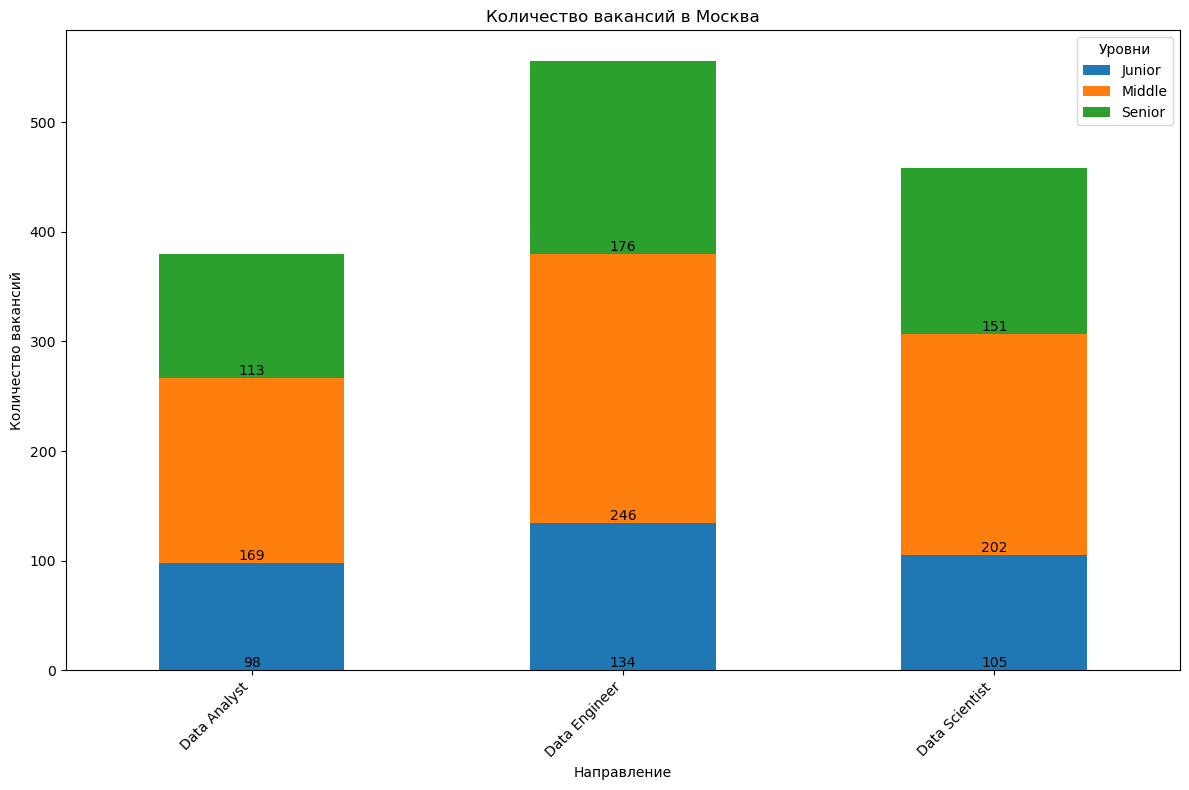

In [9]:
represent_information(df,"Москва")

<Figure size 1000x600 with 0 Axes>

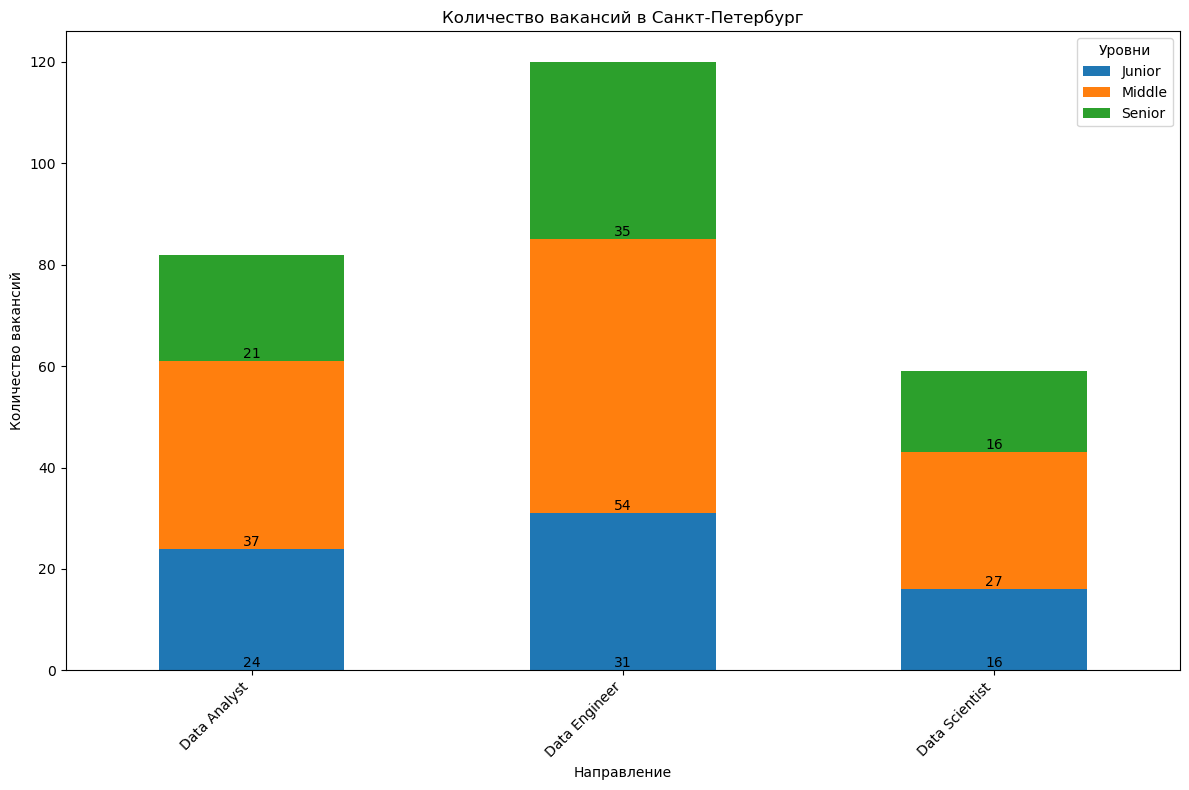

In [10]:
represent_information(df,"Санкт-Петербург")

<Figure size 1000x600 with 0 Axes>

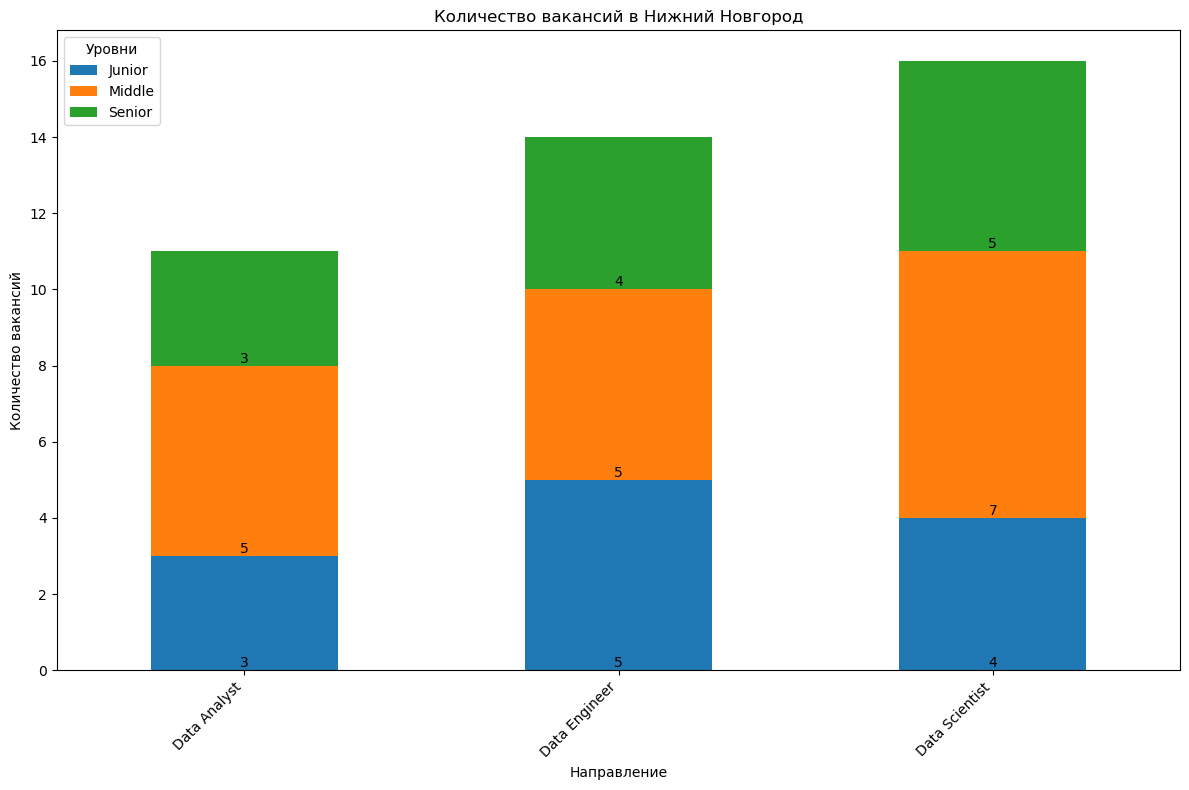

In [11]:
represent_information(df,"Нижний Новгород")